The code below models electronic response and noise by taking real data of dep and fep waveforms scaling their amplitudes to the normalized waveforms in the library of simulated data created in CreatingSignalLibrary.ipynb. A transfer function of one pole is applied to the waveforms to better model the electronic readout system and then finally randomized pink noise is added. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# This data is for energy 1598 keV for the Double Escape Peak
home_dir = '/global/homes/k/kbhimani/CPU-Net/'

# Load the .npz file
data = np.load(home_dir+'training_data/dep_waveforms.npz')

# Initialize an empty list to hold all waveforms
waveform_list = []

# Iterate over each stored array and append it to the list
for key in data.files:
    waveform = data[key]
    waveform_list.append(waveform)

# Now waveform_list contains all the waveforms
print(f"Loaded {len(waveform_list)} waveforms.")

for i in range(5):
    last_value = waveform_list[i][-1]
    print(f"Last value of waveform {i+1}: {last_value}")


sigma_values = []

# Loop through each waveform in the waveform list
for waveform in waveform_list:
    y_values = waveform[:901].astype(float)
    y_values -= y_values.mean()

    # Square and sum the result
    squared_sum = (y_values ** 2).sum()

    # Take the square root of the final answer
    sigma = np.sqrt((squared_sum)/len(y_values))

    # Append sigma value to the list
    sigma_values.append(sigma)
    
# Calculate the average sigma value
average_sigma = np.mean(sigma_values)
print("Average sigma:", average_sigma)

Loaded 9775 waveforms.
Last value of waveform 1: 5795.517578125
Last value of waveform 2: 5777.33203125
Last value of waveform 3: 5787.419921875
Last value of waveform 4: 5792.384765625
Last value of waveform 5: 5780.39453125
Average sigma: 12.784444999674637


10.765837089734049


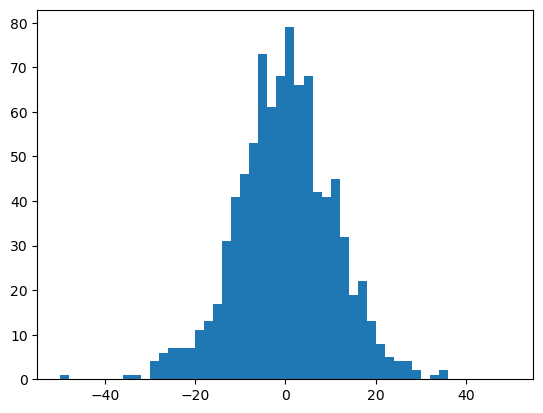

In [2]:
#plt.hist(sigma_values, bins=(100), range=(0,2))
plt.hist(y_values, bins=(50), range=(-50,50))
#plt.yscale("log")
#print(sigma_values)
print(np.sqrt((y_values**2).sum()/900))


Loaded 15000 waveforms.
Shape of first waveform: (2048,)
First waveform: [-391.16406 -391.16406 -392.16406 ... 9511.836   9503.836   9487.836  ]
Last value of waveform 1: 9487.8359375
Last value of waveform 2: 9537.052734375
Last value of waveform 3: 9517.775390625
Last value of waveform 4: 9520.697265625
Last value of waveform 5: 9517.318359375
Average sigma: 9.310071302377962


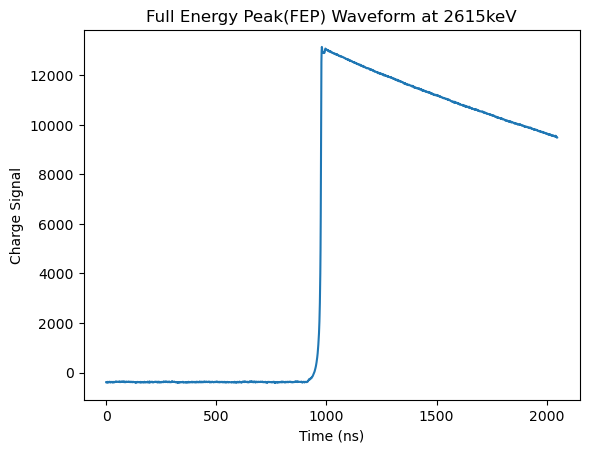

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#This data is for energy 2615 keV for Full Energy Peak 

# Load the .npz file
data = np.load(home_dir+'training_data/fep_waveforms.npz')

# Initialize an empty list to hold all waveforms
waveform_list = []

# Iterate over each stored array and append it to the list
for key in data.files:
    waveform = data[key]
    waveform_list.append(waveform)

# Now waveform_list contains all the waveforms
print(f"Loaded {len(waveform_list)} waveforms.")

# Example of using a waveform
if waveform_list:
    print("Shape of first waveform:", waveform_list[0].shape)
    print("First waveform:", waveform_list[0])
    plt.plot(waveform_list[0])
    plt.title('Full Energy Peak(FEP) Waveform at 2615keV')
    plt.xlabel('Time (ns)')
    plt.ylabel('Charge Signal')

for i in range(5):
    last_value = waveform_list[i][-1]
    print(f"Last value of waveform {i+1}: {last_value}")

sigma_values = []

# Loop through each waveform in the waveform list
for waveform in waveform_list:
    y_values = waveform[:301]
    y_values -= y_values.mean()

    # Square and sum the result
    squared_sum = (y_values ** 2).sum()

    # Take the square root of the final answer
    sigma = np.sqrt((squared_sum)/len(y_values))

    # Append sigma value to the list
    sigma_values.append(sigma)

# Calculate the average sigma value
average_sigma = np.mean(sigma_values)

print("Average sigma:", average_sigma)

In [4]:
import numpy as np
import pandas as pd
from scipy import signal

#For the real simulation the pole was taken from a time of 33700ns and we are sampling every 16ns 

time=33700
tau = 33700/16

#Creating the Transfer Function
num = [.5,0]
den = [1, 1/tau]
sys = signal.TransferFunction(num, den)

#While the system can handle multiple poles the system is non-linear and not accurately modeled by a second pole yet
num2 = [1-.983,0]
den2 = [1, 1/122]
sys2 = signal.TransferFunction(num2, den2)


df = pd.read_pickle('output_dataframe.pkl')

x = np.arange(0, 4000, 10)

def apply_transfer_function(waveform):
    _, y_response, _ = signal.lsim(sys, waveform, np.arange(len(waveform)))
    return y_response

#Will append the dataframe with a column of waveforms withe the applied transfer function
df['transformed_waveform'] = df['data_column'].apply(apply_transfer_function)
df.to_pickle('transformed_dataframe.pkl')

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the DataFrame from a pickle file
df = pd.read_pickle('output_dataframe.pkl')

# Function to normalize data
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Apply normalization to the waveform data
normalized_waveform = normalize_data(waveform)

# Scale the normalized waveform data for dep and fep
dep_scaled_waveform = normalized_waveform * 5795.517578125
fep_scaled_waveform = normalized_waveform * 9487.8359375

In [6]:
# Function to plot waveform
def plotwaveform(r_value, z_value, phi_value = round(np.pi/2, 3)):
    # Filter DataFrame by r_value and z_value
    filtered_waveform_df = df.loc[(df['z'] == z_value) & (df['r'] == r_value)]['data_column']
    filtered_transformed_df = df.loc[(df['z'] == z_value) & (df['r'] == r_value)]['transformed_waveform']

    # Check if both filtered DataFrames are not empty
    if not filtered_waveform_df.empty and not filtered_transformed_df.empty:
        # Extract waveform and transformed waveform from filtered DataFrames
        waveform = filtered_waveform_df.iloc[0]
        transformed_waveform = filtered_transformed_df.iloc[0]

        # Normalize waveform and transformed waveform data
        normalized_waveform = normalize_data(waveform)
        normalized_transformed_waveform = normalize_data(transformed_waveform)

        # Generate x-axis values
        x = np.arange(0, 4000, 10)

        # Plot normalized waveform and transformed waveform
        plt.plot(x, normalized_waveform, label='Normalized Waveform')
        plt.plot(x, normalized_transformed_waveform, label='Normalized Transformed Waveform')

        # Set labels and title for the plot
        plt.xlabel("Time [ns]", size=13)
        plt.ylabel("Charge signal", labelpad=8, size=13)
        plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
        plt.grid(True)
        plt.legend()
        plt.rcParams["figure.figsize"] = 12, 6
        plt.show()

12863it [02:06, 118.64it/s]/tmp/ipykernel_1276038/672312843.py:12: RuntimeWarning: invalid value encountered in divide
  return (data - min_val) / (max_val - min_val)
13055it [02:08, 101.64it/s]


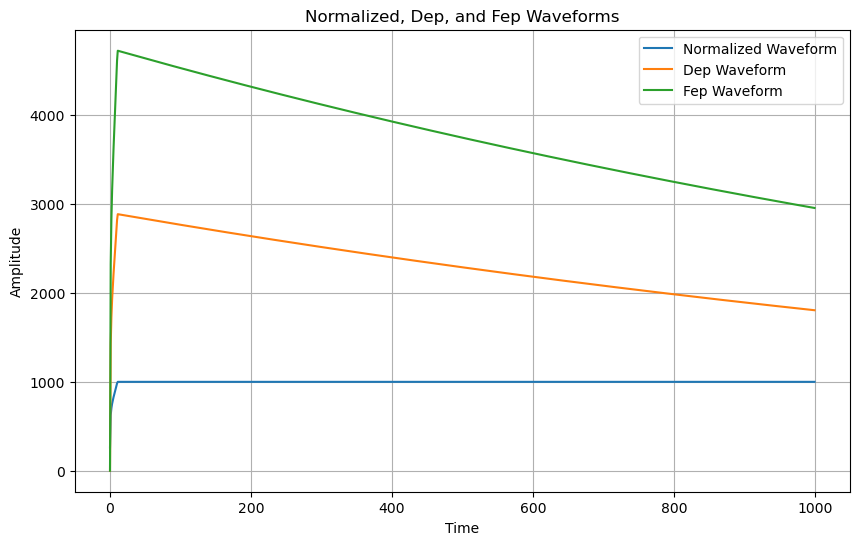

In [7]:
from scipy import signal


# Initialize lists to hold transformed waveforms
dep_transformed_list = []
fep_transformed_list = []

# Assuming data_column contains the waveforms
for i, waveform in tqdm(enumerate(df['data_column'])):
    # Normalize the waveform
    normalized_waveform = normalize_data(waveform)
    
    # Scale by dep_scaled_waveform and fep_scaled_waveform
    dep_scaled = normalized_waveform * 5795.517578125
    fep_scaled = normalized_waveform * 9487.8359375
    
    dep_transformed = apply_transfer_function(dep_scaled)
    fep_transformed = apply_transfer_function(fep_scaled)
    
    # Append transformed waveforms to lists
    dep_transformed_list.append(dep_transformed)
    fep_transformed_list.append(fep_transformed)

# Convert lists to Series objects
dep_series = pd.Series(dep_transformed_list)
fep_series = pd.Series(fep_transformed_list)

# Assign Series to new columns in the DataFrame
df['dep'] = dep_series
df['fep'] = fep_series

# Choose the index of the waveform to plot (e.g., 0 for the first waveform)
waveform_index = 3

# Retrieve the normalized waveform, dep waveform, and fep waveform for the chosen index
normalized_waveform = df['data_column'][waveform_index]
dep_waveform = df['dep'][waveform_index]
fep_waveform = df['fep'][waveform_index]

# Create a time array for plotting
time = np.arange(len(normalized_waveform))

# Plot all three waveforms on the same plot
plt.figure(figsize=(10, 6))
plt.plot(time, normalized_waveform, label='Normalized Waveform')
plt.plot(time, dep_waveform, label='Dep Waveform')
plt.plot(time, fep_waveform, label='Fep Waveform')
plt.title('Normalized, Dep, and Fep Waveforms')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Save the updated DataFrame as a new pickle file
df.to_pickle('transformed_dataframe.pkl')

12861it [03:07, 62.64it/s]/tmp/ipykernel_1276038/672312843.py:12: RuntimeWarning: invalid value encountered in divide
  return (data - min_val) / (max_val - min_val)
13055it [03:10, 68.35it/s]


1500
1500
1500


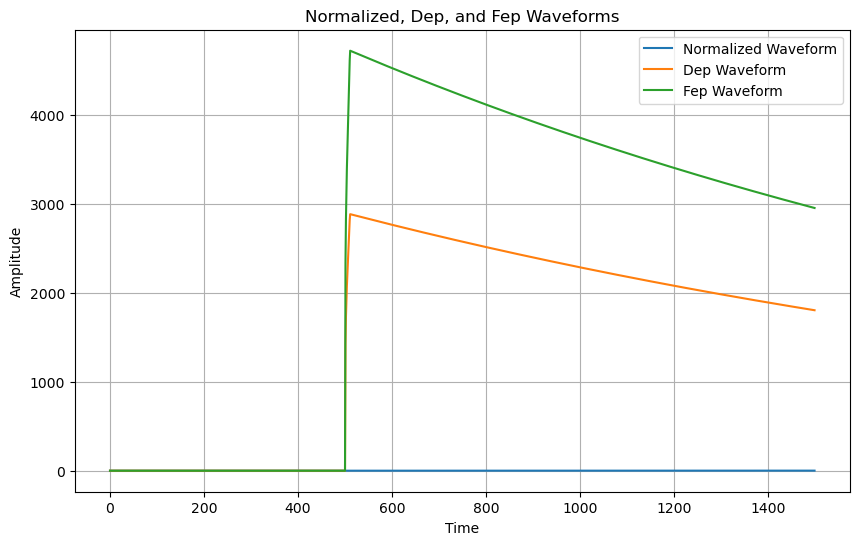

In [8]:
import numpy as np
from scipy import signal
import pandas as pd


# Load the DataFrame
df = pd.read_pickle('transformed_dataframe.pkl')

# Define the number of zero-padding data points to add at the beginning
num_padding_points = 500  # Adjust this value as needed

# Initialize lists to hold transformed waveforms
dep_transformed_list = []
fep_transformed_list = []

# Assuming data_column contains the waveforms
for i, waveform in tqdm(enumerate(df['data_column'])):

    normalized_waveform = normalize_data(waveform)
    # Pad the waveform with zeros at the beginning
    padded_waveform = np.pad(normalized_waveform, (num_padding_points, 0), mode='constant')
    
    # Scale by dep_scaled_waveform and fep_scaled_waveform
    dep_scaled = padded_waveform * 5795.517578125
    fep_scaled = padded_waveform * 9487.8359375
    
    # Apply transfer function to scaled waveforms
    dep_transformed = apply_transfer_function(dep_scaled)
    fep_transformed = apply_transfer_function(fep_scaled)
    
    # Append transformed waveforms to lists
    dep_transformed_list.append(dep_transformed)
    fep_transformed_list.append(fep_transformed)

# Convert lists to Series objects
dep_series = pd.Series(dep_transformed_list)
fep_series = pd.Series(fep_transformed_list)

# Assign Series to new columns in the DataFrame
df['dep'] = dep_series
df['fep'] = fep_series


import numpy as np
import matplotlib.pyplot as plt

# Choose the index of the waveform to plot (e.g., 0 for the first waveform)
waveform_index = 3

# Retrieve the normalized waveform, dep waveform, and fep waveform for the chosen index
dep_waveform = df['dep'][waveform_index]
fep_waveform = df['fep'][waveform_index]
print(len(dep_waveform))
print(len(fep_waveform))
print(len(padded_waveform))
# Create a time array for plotting
time = np.arange(len(padded_waveform))

# Plot all three waveforms on the same plot
plt.figure(figsize=(10, 6))
plt.plot(time, padded_waveform, label='Normalized Waveform')
plt.plot(time, dep_waveform, label='Dep Waveform')
plt.plot(time, fep_waveform, label='Fep Waveform')
plt.title('Normalized, Dep, and Fep Waveforms')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# Save the updated DataFrame as a new pickle file
df.to_pickle('transformed_dataframe_with_padding.pkl')


In [9]:
print(df)

          r    phi     z                                        data_column  \
0       0.0  1.571   2.0  [235.81141662597656, 526.297119140625, 651.911...   
1       0.0  1.571   2.5  [307.5109558105469, 566.4334716796875, 672.219...   
2       0.0  1.571   3.0  [312.3950500488281, 598.9055786132812, 688.928...   
3       0.0  1.571   3.5  [263.9278259277344, 625.6439208984375, 703.752...   
4       0.0  1.571   4.0  [205.0671844482422, 613.1870727539062, 717.368...   
...     ...    ...   ...                                                ...   
13050  39.5  1.571  92.5  [0.000331078510498628, 0.0008729041437618434, ...   
13051  39.5  1.571  93.0  [0.0002423530531814322, 0.0006555577274411917,...   
13052  39.5  1.571  93.5  [0.00016413100820500404, 0.0004627483431249857...   
13053  39.5  1.571  94.0  [9.472551028011367e-05, 0.00028836322599090636...   
13054  39.5  1.571  94.5  [3.6136392736807466e-05, 0.000129226827993989,...   

                                                   

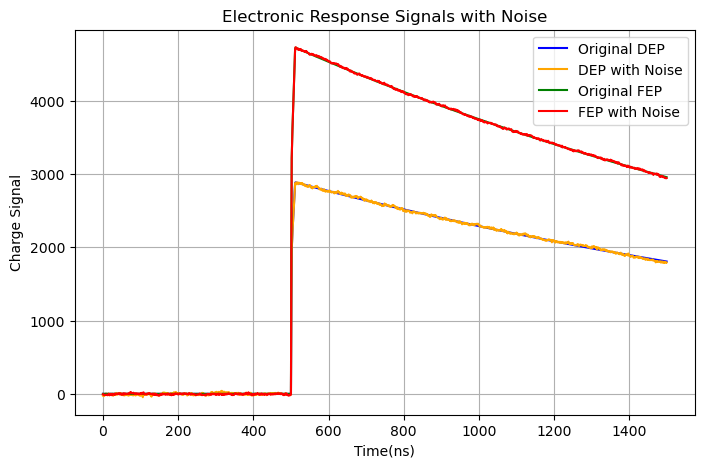

In [10]:
import numpy as np
import pandas as pd

def noise_psd(N, psd=lambda f: 1):
    X_white = np.fft.rfft(np.random.randn(N))
    S = psd(np.fft.rfftfreq(N))
    # Normalize S
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S
    return np.fft.irfft(X_shaped)

def PSDGenerator(f):
    return lambda N, scale: noise_psd(N, f) * scale

@PSDGenerator
def pink_noise(f):
    return 1 / np.where(f == 0, float('inf'), np.sqrt(f))

# Load the DataFrame
df = pd.read_pickle('transformed_dataframe_with_padding.pkl')

# Define noise scale
dep_noise_scale = 12.784444999674637
fep_noise_scale = 9.310071302377962

# Initialize lists to store generated noise signals
dep_with_noise_list = []
fep_with_noise_list = []
original_waveform_list = df['data_column'].tolist()

# Iterate through each waveform and add pink noise
for i in range(len(df)):
    # Generate pink noise signals for dep and fep waveforms
    dep_pink_noise_signal_transformed = pink_noise(len(df['dep'][i]), dep_noise_scale)[:len(df['dep'][i])]
    fep_pink_noise_signal_transformed = pink_noise(len(df['fep'][i]), fep_noise_scale)[:len(df['fep'][i])]
    
    # Add pink noise to dep and fep transformed waveforms
    dep_transformed_waveform_with_noise = df['dep'][i] + dep_pink_noise_signal_transformed
    fep_transformed_waveform_with_noise = df['fep'][i] + fep_pink_noise_signal_transformed
    
    # Append generated noise signals to lists
    dep_with_noise_list.append(dep_transformed_waveform_with_noise)
    fep_with_noise_list.append(fep_transformed_waveform_with_noise)

# Convert lists to DataFrame columns
df['dep_with_noise'] = dep_with_noise_list
df['fep_with_noise'] = fep_with_noise_list

# Save the updated DataFrame as a new pickle file
df.to_pickle('transformed_dataframe_with_noise.pkl')
import matplotlib.pyplot as plt

# Load the DataFrame with noise
df_with_noise = pd.read_pickle('transformed_dataframe_with_noise.pkl')

# Select a row index to plot (you can choose any index within the range of your DataFrame)
row_index = 5

# Extract original and noisy waveforms
original_dep = df['dep'][row_index]
noisy_dep = df_with_noise['dep_with_noise'][row_index]
original_fep = df['fep'][row_index]
noisy_fep = df_with_noise['fep_with_noise'][row_index]

# Create time array
time_dep = np.arange(len(original_dep))
time_fep = np.arange(len(original_fep))

# Plot both waveforms (DEP and FEP) with and without noise
plt.figure(figsize=(8, 5))

plt.plot(time_dep, original_dep, label='Original DEP', color='blue')
plt.plot(time_dep, noisy_dep, label='DEP with Noise', color='orange')
plt.plot(time_fep, original_fep, label='Original FEP', color='green')
plt.plot(time_fep, noisy_fep, label='FEP with Noise', color='red')

plt.title('Electronic Response Signals with Noise')
plt.xlabel('Time(ns)')
plt.ylabel('Charge Signal')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(df_with_noise)

          r    phi     z                                        data_column  \
0       0.0  1.571   2.0  [235.81141662597656, 526.297119140625, 651.911...   
1       0.0  1.571   2.5  [307.5109558105469, 566.4334716796875, 672.219...   
2       0.0  1.571   3.0  [312.3950500488281, 598.9055786132812, 688.928...   
3       0.0  1.571   3.5  [263.9278259277344, 625.6439208984375, 703.752...   
4       0.0  1.571   4.0  [205.0671844482422, 613.1870727539062, 717.368...   
...     ...    ...   ...                                                ...   
13050  39.5  1.571  92.5  [0.000331078510498628, 0.0008729041437618434, ...   
13051  39.5  1.571  93.0  [0.0002423530531814322, 0.0006555577274411917,...   
13052  39.5  1.571  93.5  [0.00016413100820500404, 0.0004627483431249857...   
13053  39.5  1.571  94.0  [9.472551028011367e-05, 0.00028836322599090636...   
13054  39.5  1.571  94.5  [3.6136392736807466e-05, 0.000129226827993989,...   

                                                   

In [12]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

data = df_with_noise
pickle_path_data_column = home_dir+'/training_data/valid_sim.pkl'
pickle_path_transformed_waveform = home_dir+'/training_data/valid_transfromed.pkl'
with open(pickle_path_data_column, 'wb') as f_data, open(pickle_path_transformed_waveform, 'wb') as f_transformed:
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Data"):
        event_id = index  
        energy = 0
        
        # Process 'data_column'
        waveform_data = np.array(data["data_column"][index])
        if waveform_data is not None:
            event_dict_data = {
                "tp0": 0,
                "wf": waveform_data.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_data, f_data, protocol=pickle.HIGHEST_PROTOCOL)
        
        # Process 'transformed_waveform'
        waveform_transformed = np.array(data["dep_with_noise"][index])
        if waveform_transformed is not None:
            event_dict_transformed = {
                "tp0": 0,
                "wf": waveform_transformed.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_transformed, f_transformed, protocol=pickle.HIGHEST_PROTOCOL)
    print("Completed saving waveforms.")

Processing Data: 100%|██████████| 13055/13055 [00:01<00:00, 8745.12it/s]

Completed saving waveforms.
